# Introduction to Problem of Brain Tumor

A brain tumor is one of the most dangerous diseases that can affect both children and adults. The majority of primary Central Nervous System (CNS) tumors are brain tumors, which account for 85 to 90% of all cases. Around 11,700 people are diagnosed with a brain tumor each year. People with a cancerous brain or CNS tumor have a 5-year survival rate of approximately 34% for men and 36% for women. Glioma Tumors, Meningioma Tumors, Pituitary Tumors, and other types of brain tumors are classified. To increase the patients' life expectancy, proper treatment, planning, and accurate diagnostics should be implemented. Magnetic Resonance Imaging (MRI) is the most effective method for detecting brain tumors. The scans generate a tremendous amount of image data. The radiologist inspects these photographs. Because of the complexity involved in brain tumors and their properties, a manual examination can be prone to errors.

# Objective

Deep learning is being used to forecast a variety of brain tumor. The major objectives of this notebook are to attain a high level of brain tumor prediction accuracy. Deep learning approaches assist in the early diagnosis of brain tumor. The classification of brain tumor relies heavily on feature extraction. Human labor, such as manual feature extraction and data reconstruction for classification purposes, is reduced when Deep Learning algorithms are used. As a result, proposing a system that uses Deep Learning Algorithms using Convolution Neural Network (CNN) and Transfer Learning (TL) to do classification will be beneficial to doctors all over the world.

# Description of the Brain Tumor Dataset



The dataset is organized into 2 folders (Training, Testing) and contains 4 subfolders for each image category. There are 3,264 MRI images (JPEG) and 4 categories (Glioma/Meningioma/Pituitary/No_tumor).
1. Training set
* Glioma tumor (826 images)
* Meningioma tumor (822 images)
* No tumor (395 images)
* Pituitary tumor (827 images)
2. Testing set
* Glioma tumor (100 images)
* Meningioma tumor (115 images)
* No tumor (105 images)
* Pituitary tumor (74 images)

# Importing the necessary libraries

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

import io
from PIL import Image
from tqdm import tqdm
from keras import layers

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import ipywidgets as widgets
from IPython.display import display, clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preperation

Appending all the images from the directories into a list and then converting them into numpy arrays after resizing it.

In [ ]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X_train, y_train, X_test, y_test  = [],[],[],[]

image_size = 64
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/VR-S_Workshop/BTC Dataset/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/VR-S_Workshop/BTC Dataset/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 74/74 [00:15<00:00,  4.67it/s]


**Previewing the images in each classes**

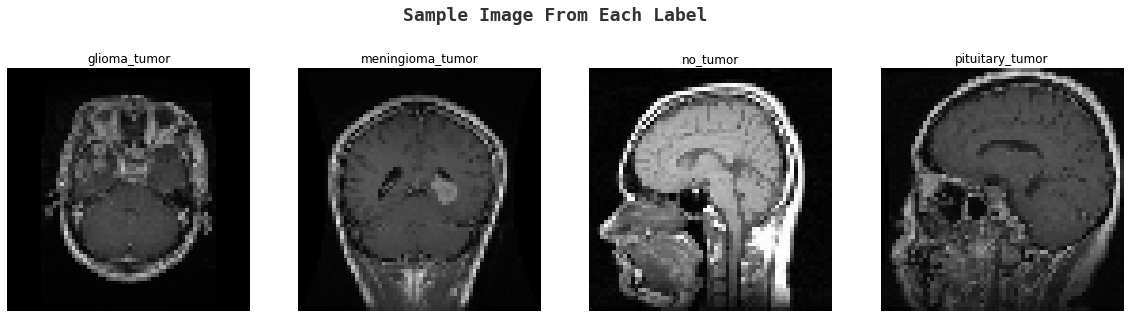

In [ ]:
k=0
fig, ax = plt.subplots(1,2,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold', fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

**Shuffle the train set**

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=14)

**Print out dataset shape**

In [ ]:
X_train.shape, X_test.shape

(2870, 64, 64, 3)

**Performing One Hot Encoding on the labels after converting it into numerical values**

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

**Normalize the data**

In [ ]:
X_train = np.array(X_train) / 255.
X_test = np.array(X_test) / 255.

**Data Augmentation**


To prevent the problem of overfitting, we can artificially enlarge the dataset. I can increase the size of the current dataset. The idea is to alter the training data with small transformations to reproduce the variations.   Data augmentation strategies are methods for changing the array representation while keeping the label the same while altering the training data. Grayscales, horizontal and vertical flips, random crops, color jitters, translations, rotations, and many other augmentations are popular. I can easily double or increase the number of training examples by applying only a couple of these changes to the training data.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=True,  # divide each input by its std
        zca_whitening=True,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1,  # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


For the data augmentation, i choosed to :
1.   Randomly rotate some training images by 10 degrees.
2.   Randomly Zoom by 10% some training images.
3.   Randomly shift images horizontally by 10% of the width.
4.   Randomly shift images vertically by 10% of the height.
5.   Randomly flip images horizontally.

**Callback function**


Callbacks can help fix bugs more quickly, and can help build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.

By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/VR-S_Workshop/effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

# Detail of model implementation

**CNN approach**

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv2D(64, (3, 3), padding='same',input_shape=(image_size,image_size,3))) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3))) 
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2))) 
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization()) 

model_cnn.add(Flatten()) 
model_cnn.add(Dropout(0.5)) 
model_cnn.add(Dense(512)) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dense(4)) 
model_cnn.add(Activation('softmax'))

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 62, 62, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                      

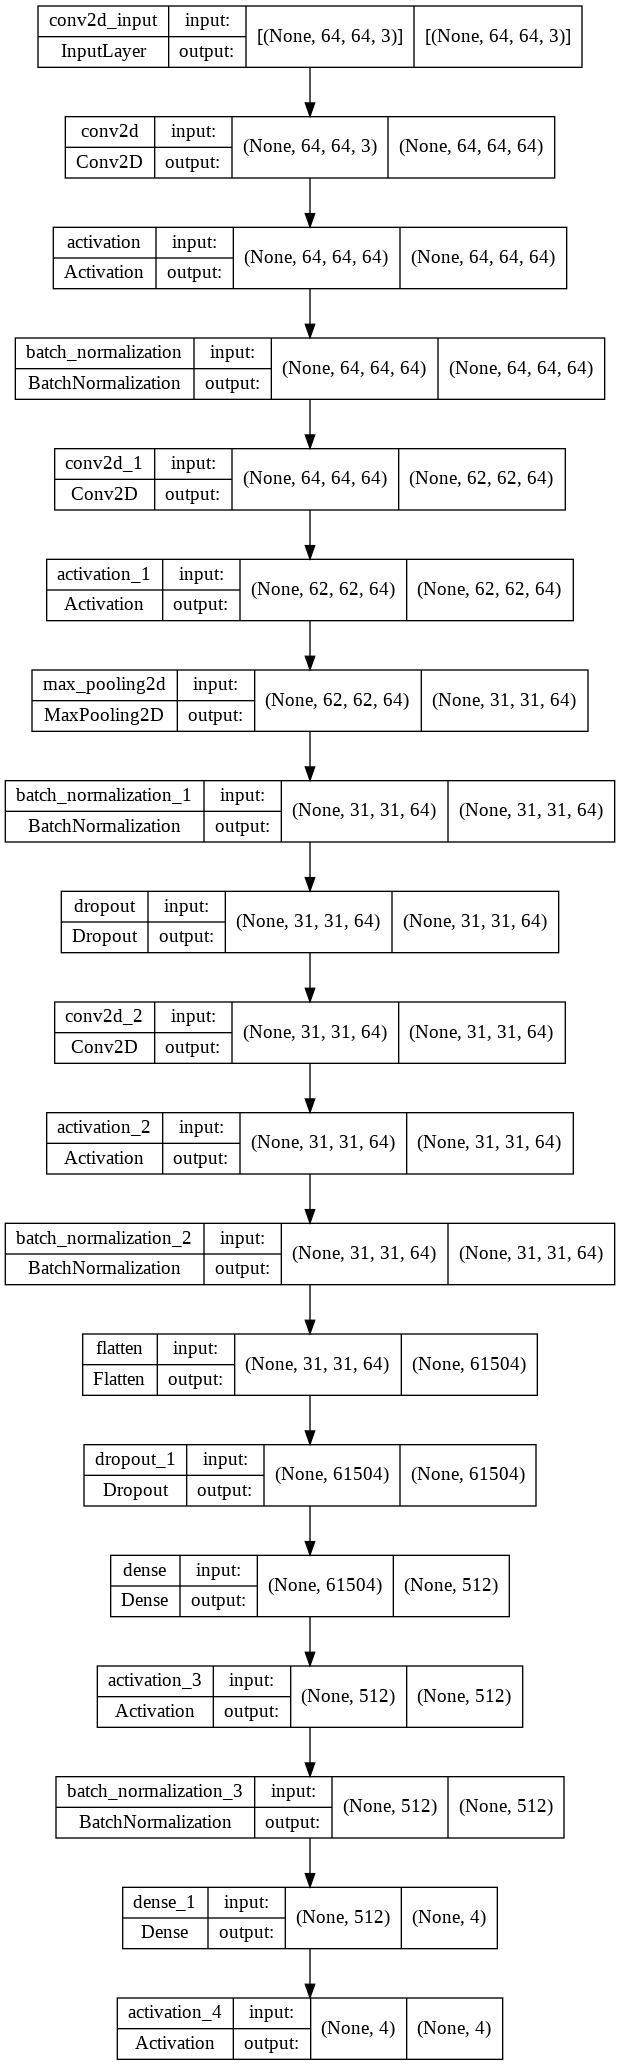

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn, to_file='/content/drive/MyDrive/VR-S_Workshop//model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_cnn.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [ ]:
history = model_cnn.fit(X_train, y_train, verbose=1, batch_size = 32, validation_data = (X_test, y_test), epochs = 2, callbacks =[checkpoint,reduce_lr])

Epoch 1/2
81/81 [==============================] - ETA: 0s - loss: 0.9897 - accuracy: 0.7189
Epoch 1: val_accuracy improved from -inf to 0.30662, saving model to /content/drive/MyDrive/VR-S_Workshop/effnet.h5
81/81 [==============================] - 22s 146ms/step - loss: 0.9897 - accuracy: 0.7189 - val_loss: 3.9334 - val_accuracy: 0.3066 - lr: 0.0010
Epoch 2/2
81/81 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8544
Epoch 2: val_accuracy did not improve from 0.30662
81/81 [==============================] - 5s 57ms/step - loss: 0.3891 - accuracy: 0.8544 - val_loss: 3.8663 - val_accuracy: 0.2962 - lr: 0.0010


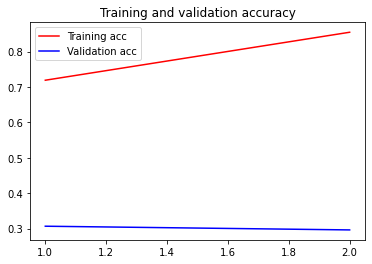

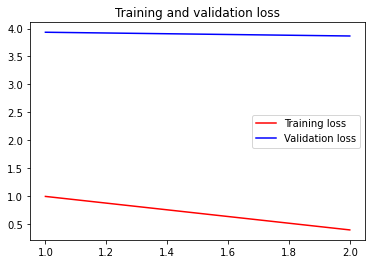

In [ ]:
model_cnn.save('/content/drive/MyDrive/VR-S_Workshop/cnn_model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Prediction**

I've used the argmax function as each row from the prediction array contains four values for the respective labels. The maximum value which is in each row depicts the predicted output out of the 4 possible outcomes.
So with argmax, I'm able to find out the index associated with the predicted outcome.

In [ ]:
pred = model_cnn.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 17.51%


**Evaluation**

In [ ]:
model_cnn.evaluate(X_train, y_train)

81/81 [==============================] - 1s 17ms/step - loss: 3.9898 - accuracy: 0.3159


[3.9898040294647217, 0.31591174006462097]

In this,

*   0 - Glioma Tumor
*   1 - Meningioma Tumor
*   2 - No Tumor
*   3 - Pituitary Tumo

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.26      0.05      0.08       100
           1       0.00      0.00      0.00       115
           2       0.00      0.00      0.00       105
           3       0.17      0.86      0.29        74

    accuracy                           0.18       394
   macro avg       0.11      0.23      0.09       394
weighted avg       0.10      0.18      0.07       394



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


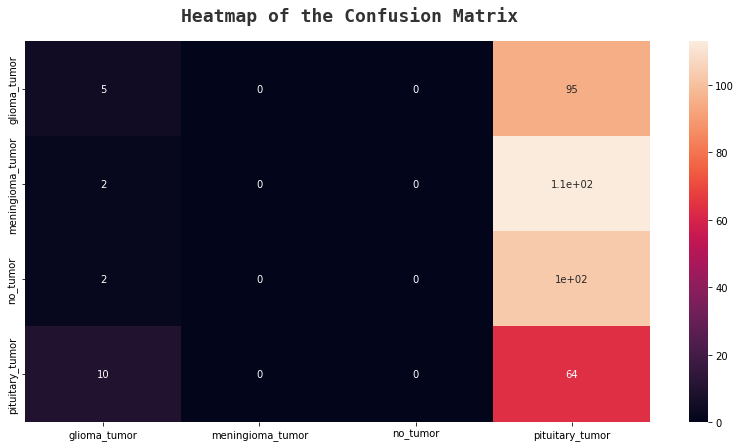

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold', fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

**Transfer Learning approach**

Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task. In this project I use pretrained models like VGG-16 and EfficientNetB0. Which is trained on large ImageNet dataset.

The ImageNet project is a large visual database designed for use in visual object recognition software research. More than 14 million images have been hand-annotated by the project to indicate what objects are pictured and in at least one million of the images, bounding boxes are also provided. ImageNet contains more than 20,000 categories with a typical category, such as "balloon" or "strawberry", consisting of several hundred images.

**VGG16**

The include_top parameter is set to False so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [ ]:
vgg=VGG16(input_shape=(image_size,image_size,3) , weights='imagenet' , include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
for layers in vgg.layers:
  layers.trainable=False

In [ ]:
model_vgg = vgg.output
model_vgg = GlobalAveragePooling2D()(model_vgg)
model_vgg = Dense(128,activation='relu')(model_vgg)
model_vgg = Dropout(0.15)(model_vgg)
model_vgg = Dense(4,activation='softmax')(model_vgg)
model_vgg = Model(inputs=vgg.input,outputs=model_vgg)
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

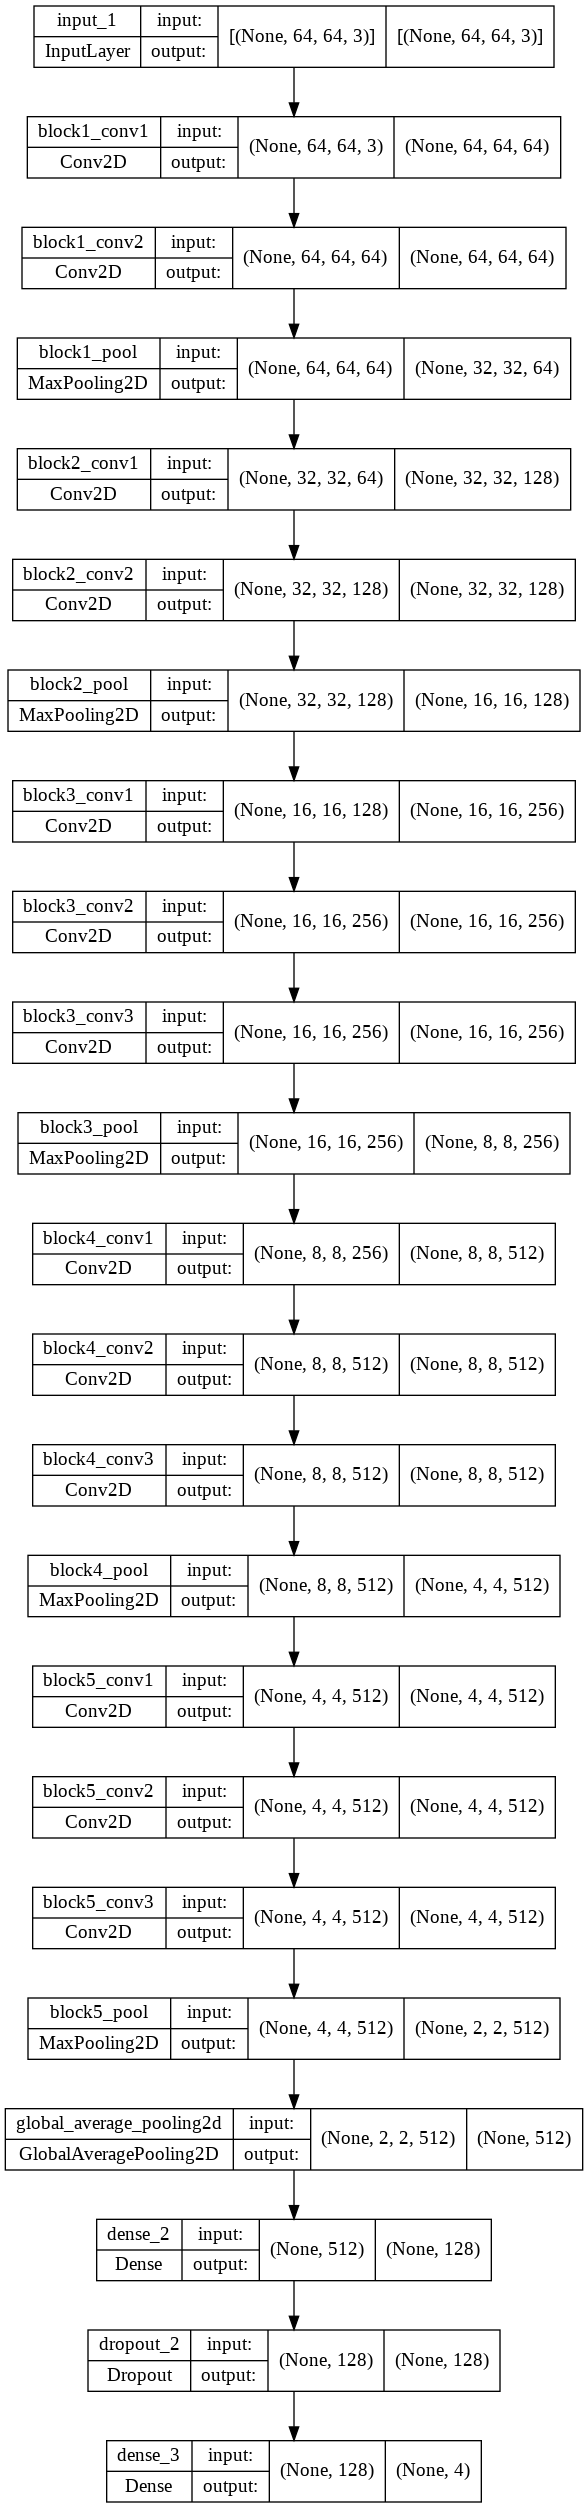

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_vgg, to_file='model_vgg_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_vgg.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [ ]:
history = model_vgg.fit(X_train, y_train, verbose=1, batch_size = 32, validation_data = (X_test, y_test), epochs = 2, callbacks =[checkpoint,reduce_lr])

Epoch 1/2
81/81 [==============================] - ETA: 0s - loss: 0.9513 - accuracy: 0.6078
Epoch 1: val_accuracy improved from 0.30662 to 0.68990, saving model to /content/drive/MyDrive/VR-S_Workshop/effnet.h5
81/81 [==============================] - 9s 89ms/step - loss: 0.9513 - accuracy: 0.6078 - val_loss: 0.7973 - val_accuracy: 0.6899 - lr: 0.0010
Epoch 2/2
80/81 [============================>.] - ETA: 0s - loss: 0.6817 - accuracy: 0.7195
Epoch 2: val_accuracy improved from 0.68990 to 0.73519, saving model to /content/drive/MyDrive/VR-S_Workshop/effnet.h5
81/81 [==============================] - 4s 51ms/step - loss: 0.6800 - accuracy: 0.7201 - val_loss: 0.6845 - val_accuracy: 0.7352 - lr: 0.0010


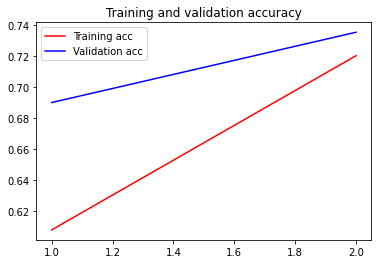

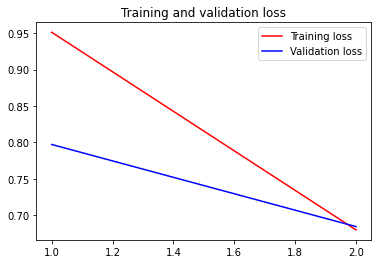

In [ ]:
model_vgg.save('/content/drive/MyDrive/VR-S_Workshop/vgg16_model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Prediction**

In [ ]:
pred = model_vgg.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 43.91%


**Evaluation**

In [ ]:
model_vgg.evaluate(X_train, y_train)

81/81 [==============================] - 3s 38ms/step - loss: 0.5977 - accuracy: 0.7627


[0.5976880788803101, 0.7626790404319763]

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.37      0.19      0.25       100
           1       0.51      0.37      0.43       115
           2       0.35      0.64      0.46       105
           3       0.64      0.59      0.62        74

    accuracy                           0.44       394
   macro avg       0.47      0.45      0.44       394
weighted avg       0.46      0.44      0.43       394



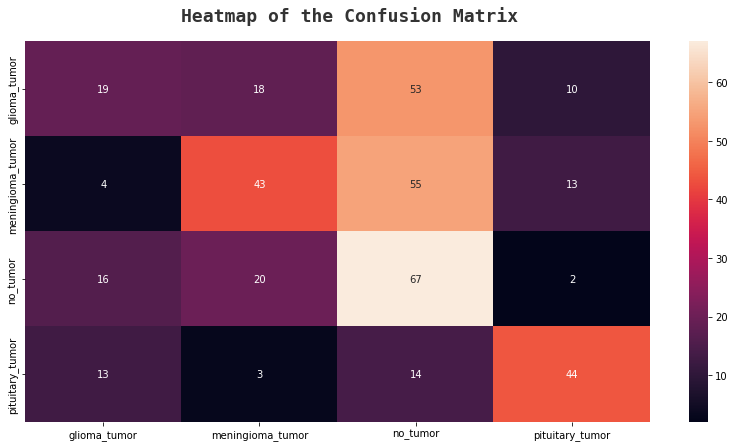

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

# Experimental results

In [ ]:
# Function to convert output labels to its class of tumor.
def inverse_classes(num):
    if num==0:
        return 'Glioma Tumor'
    elif num==1:
        return 'Meningioma Tumor'
    elif num==2:
        return 'No Tumor'
    else:
        return 'Pituitary Tumor'

**Prediction using CNN model**

In [ ]:
train_pred = model_cnn.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

In [ ]:
test_pred = model_cnn.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

Accuracy on testing set: 17.51%


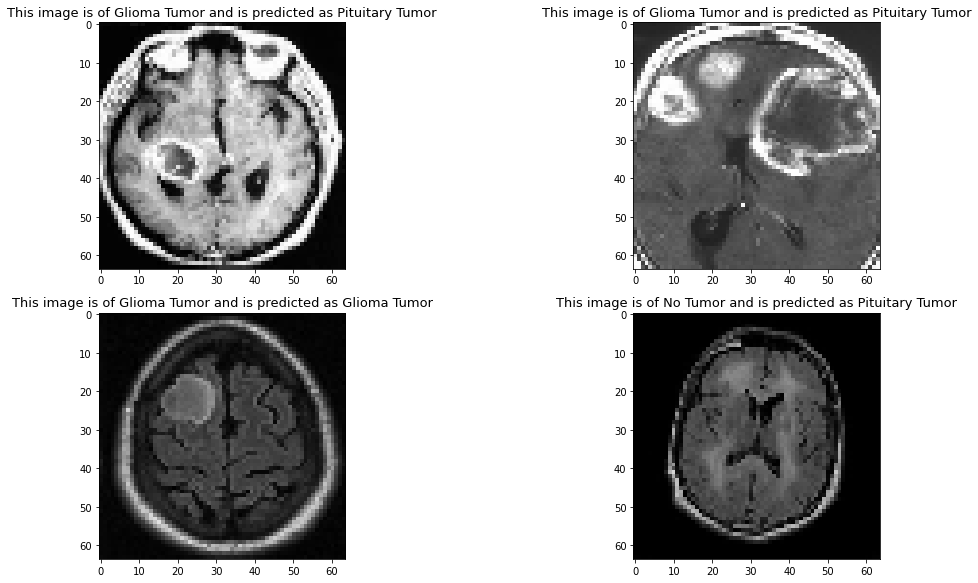

In [ ]:
# Prediction using CNN model
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model_cnn.predict(np.reshape(X_test[index],(-1,image_size,image_size,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()

**Prediction using VGG16 model**

In [ ]:
train_pred = model_vgg.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

Accuracy on training set: 76.27%


In [ ]:
test_pred = model_vgg.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

Accuracy on testing set: 43.91%


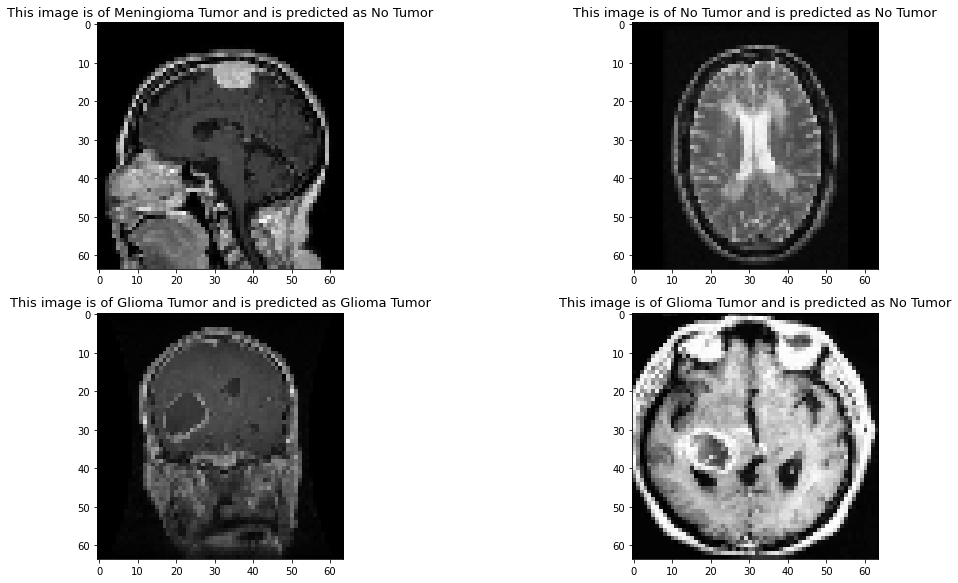

In [ ]:
# Prediction using VGG16 model
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model_vgg.predict(np.reshape(X_test[index],(-1,image_size,image_size,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()